一个英伟达Volta V100 GPU上用100%的计算力，训练将需要多长时间。网络在一张32×32×3的CIFAR10图像上进行前向和后向传递时需要大约2.8×10^9FLOPs。假设参数更新不耗费计算力，那么在50000张图像训练35个epoch应该会在5×10^15FLOPs以内完成
> Tesla V100有640个Tensor Cores，能支持125 TeraFLOPS的深度学习性能。

假设我们能发挥100%的计算力，那么训练会在40秒内完成，这么看来341秒的成绩还有很大的提升空间。

### Set GPU clocks

In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [2]:
import sys
print(sys.path)

['/home/ubuntu/src/cntk/bindings/python', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload', '', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/bask-0.6.0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scikit_optimize-0.8.dev0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pyaml-20.4.0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions', '/home/ubuntu/.ipython']


In [3]:
# 移动到notebook/ 文件下调用
sys.path.append("..")
print(sys.path)

['/home/ubuntu/src/cntk/bindings/python', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload', '', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/bask-0.6.0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/emcee-3.0.2-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scikit_optimize-0.8.dev0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pyaml-20.4.0-py3.6.egg', '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions', '/home/ubuntu/.ipython', '..']


In [4]:
from core import *
from torch_backend import *

### Network definition

In [8]:
# new

batch_norm = partial(BatchNorm, weight_init=None, bias_init=None)

def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    block['add'] = (Add(), [('conv3' if projection else 'relu1'), 'branch/conv2'])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):
    if isinstance(c, int):
        c = [c, 2 * c, 4 * c, 4 * c]

    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), ['in']),
        'concat': (Concat(), ['maxpool', 'avgpool']),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}

    return {
        'input': (None, []),
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2 * c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'logits': Identity(),
    }

def conv_bn(c_in, c_out, ks=3, bn_weight_init=1.0, **kw):
    if isinstance(ks, list):
        basic = {}
        for ks_ in ks:
            basic[str(ks_)] =  {'conv': nn.Conv2d(c_in, c_out, kernel_size=ks_, stride=1, padding=ks_//2, bias=False),
                                'bn': batch_norm(c_out, **kw),
                                'relu': nn.ReLU(True)}
    else:
        basic = None

    return basic or {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=ks, stride=1, padding=ks//2, bias=False),
        'bn': batch_norm(c_out, **kw),
        'relu': nn.ReLU(True)
        # 'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw),
        # 'bn': GhostBatchNorm(c_out, num_splits=2, **kw),
    }

def basic_net(ks, channels, weight, pool, num_classes, **kw):
    return {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep'], ks=ks, bn_weight_init=1.0, **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], ks=ks, **kw), pool=pool), # 32->16
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], ks=ks, **kw), pool=pool), # 16->8
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], ks=ks, **kw), pool=pool), # 8->4
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], num_classes, bias=False),
        'logits': Mul(weight),
    }

def net(weight=0.125,
        channels=None,
        pool=nn.MaxPool2d(2),
        extra_layers={'prep':0, 'layer1':0, 'layer2':0, 'layer3':0},
        res_layers  ={'prep':0, 'layer1':0, 'layer2':0, 'layer3':0},
        num_classes=10,
        ks=3,
        **kw):

    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    layer2assignment = {'prep': '32', 'layer1':'16', 'layer2':'8', 'layer3':'4'} # divided by pooling
    assignment = {'32': 2, '16': 1, '8': 1, '4': 0}  # pooling+ maxpooling

    # defined residual: in+(res1+res2+relu)
    residual = lambda c, **kw: {'in': Identity(),
                                'res1': conv_bn(c, c, **kw),
                                'res2': conv_bn(c, c, **kw),
                                'add': (Add(), ['in', 'res2/relu'])}

    n = basic_net(ks, channels, weight, pool, num_classes, **kw)

    for layer in res_layers: # residual
        times = res_layers[layer]
        if times==0:
            continue
        for i in range(times):
            n[layer]['residual{}'.format(i+1)] = residual(channels[layer], **kw)
            assignment[layer2assignment[layer]]+=2

    for layer in extra_layers: # extra
        times = extra_layers[layer]
        if times==0:
            continue
        for i in range(times):
            n[layer]['extra{}'.format(i+1)] = conv_bn(channels[layer], channels[layer], **kw)
            assignment[layer2assignment[layer]]+=1

    return n, assignment

In [69]:
def conv_bn(c_in, c_out):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': BatchNorm(c_out), 
        'relu': nn.ReLU(True)
    }

def residual(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'add': (Add(), ['in', 'res2/relu']),
    }

def residual_3(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'res3': conv_bn(c, c),
        'add': (Add(), ['in', 'res3/relu']),
    }

def net(channels=None, 
        weight=0.125, 
        pool=nn.MaxPool2d(2), 
        extra_layers=(), 
        res_layers=('layer1', 'layer3')):
    
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep']),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1']), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2']), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3']), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }
    

    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer])
        # n[layer]['residual_3'] = residual_3(channels[layer])
    
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer])      
 
    return n

### Network visualisation

```test
网络扩增且权重复用的顺序:
resolution:[32,    32->16,            16->8,             8->4         ,     4->1      ]
layers    :[prep,  layer1,            layer2,            layer3       ,     pooling   ]
conv      :[conv3, conv3+pooling,     conv3+pooling,     conv3+pooling,     maxpooling]

1. without residual only extra: +conv

conv      :[conv3, conv3+pooling       +[E],  conv3+pooling       +[E], conv3+pooling       +[E], maxpooling]

2. without residual only extra *3: +2conv

conv      :[conv3, conv3+pooling      +[3E],  conv3+pooling      +[3E], conv3+pooling      +[3E], maxpooling]

3. with residual :  +shortcut

conv      :[conv3, conv3+pooling       +[R],  conv3+pooling       +[R], conv3+pooling       +[R], maxpooling]

4. residual(default=2) + extra: +conv

conv      :[conv3, conv3+pooling+ [R]+  [E],  conv3+pooling+ [R]+  [E], conv3+pooling+ [R]+  [E], maxpooling]

5. the order between [R] and [E]: change chortcut

conv      :[conv3, conv3+pooling+ [E]+  [R],  conv3+pooling+ [E]+  [R], conv3+pooling+ [E]+  [R], maxpooling]

6. the order between [R] and [3R]: multi-shortcut

conv      :[conv3, conv3+pooling+ [E]+ [3R],  conv3+pooling+ [E]+ [3R], conv3+pooling+ [E]+ [3R], maxpooling]


```



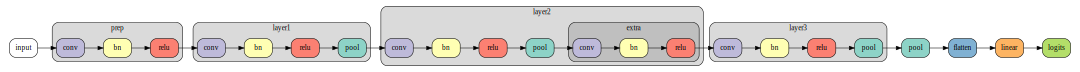

In [70]:
# without residual
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})
draw(build_graph(net(res_layers=(), extra_layers=('layer2', ))))


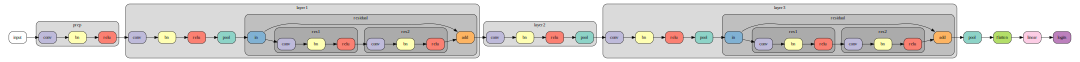

In [51]:
# 8 resnet : baseline
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})
draw(build_graph(net()))

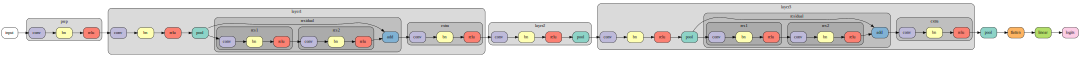

In [52]:
# remove identity_nodes compare before
remove_identity_nodes = lambda net: remove_by_type(net, Identity)
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})
draw(remove_identity_nodes(net(extra_layers=('layer1', 'layer3'))))

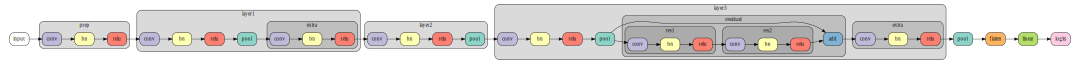

In [56]:
# remove identity_nodes compare before
remove_identity_nodes = lambda net: remove_by_type(net, Identity)
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})
draw(remove_identity_nodes(net(extra_layers=('layer1', 'layer3'), res_layers=('layer3',))))

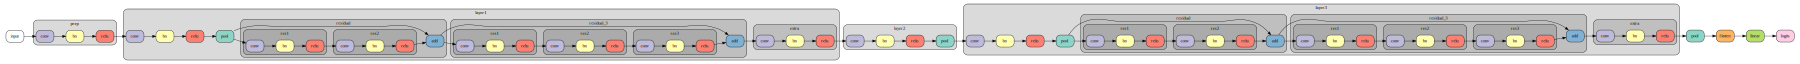

In [59]:
# residual_3
# remove identity_nodes compare before
remove_identity_nodes = lambda net: remove_by_type(net, Identity)
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}, size=25)
draw(remove_identity_nodes(net(extra_layers=('layer1', 'layer3'))))

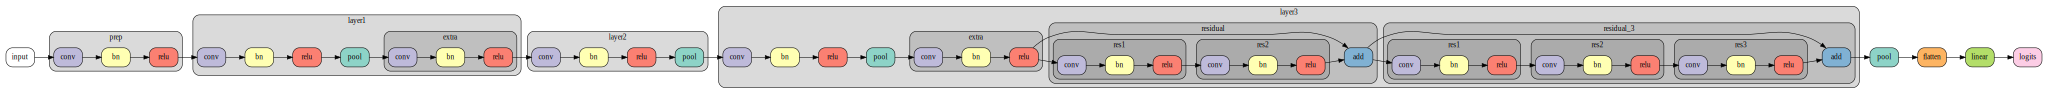

In [63]:
# residual_3
# remove identity_nodes compare before
remove_identity_nodes = lambda net: remove_by_type(net, Identity)
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}, size=35)
draw(remove_identity_nodes(net(extra_layers=('layer1', 'layer3'), res_layers=('layer3',))))


In [ ]:
# nni 搜出来的结构

In [49]:
# 77.78
RCV_CONFIG = {
    "peak_lr": 0.5330051825212991,
    "prep": 64,
    "layer1": 128,
    "layer2": 256,
    "layer3": 512,
    "extra_prep": 2,
    "extra_layer1": 0,
    "extra_layer2": 0,
    "extra_layer3": 0,
    "res_prep": 1,
    "res_layer1": 2,
    "res_layer2": 0,
    "res_layer3": 1
}

In [5]:
#78.01
RCV_CONFIG ={
    "peak_lr": 0.6138549178275754,
    "prep": 64,
    "layer1": 112,
    "layer2": 256,
    "layer3": 512,
    "extra_prep": 1,
    "extra_layer1": 0,
    "extra_layer2": 0,
    "extra_layer3": 0,
    "res_prep": 2,
    "res_layer1": 3,
    "res_layer2": 3,
    "res_layer3": 1
}

In [6]:
base_wd = RCV_CONFIG['base_wd'] if 'base_wd' in RCV_CONFIG else 5e-4
logits_weight = RCV_CONFIG['logits_weight'] if 'logits_weight' in RCV_CONFIG else 0.125
peak_epoch = RCV_CONFIG['peak_epoch'] if 'peak_epoch' in RCV_CONFIG else 5
cutout_size = RCV_CONFIG['cutout'] if 'cutout' in RCV_CONFIG else 8
total_epoch = RCV_CONFIG['total_epoch'] if 'total_epoch' in RCV_CONFIG else 24
peak_lr = RCV_CONFIG['peak_lr'] if 'peak_lr' in RCV_CONFIG else 0.4

channels = {'prep': RCV_CONFIG['prep'], 'layer1': RCV_CONFIG['layer1'], 'layer2': RCV_CONFIG['layer2'], 'layer3': RCV_CONFIG['layer3']} if 'prep' in RCV_CONFIG \
    else {'prep': 48, 'layer1': 112, 'layer2': 256, 'layer3': 384}

extra_layers = {'prep': RCV_CONFIG['extra_prep'], 'layer1': RCV_CONFIG['extra_layer1'], 'layer2': RCV_CONFIG['extra_layer2'], 'layer3': RCV_CONFIG['extra_layer3']} if 'extra_prep' in RCV_CONFIG \
    else {'prep': 0, 'layer1': 1, 'layer2': 0, 'layer3': 0}

res_layers = {'prep': RCV_CONFIG['res_prep'], 'layer1': RCV_CONFIG['res_layer1'], 'layer2': RCV_CONFIG['res_layer2'], 'layer3': RCV_CONFIG['res_layer3']} if 'res_prep' in RCV_CONFIG \
    else {'prep': 0, 'layer1': 0, 'layer2': 0, 'layer3': 2}

In [9]:
# Design search space
n, assignment = net(weight=logits_weight,
        channels=channels,
        extra_layers=extra_layers,
        res_layers=res_layers,
        num_classes=100)

In [10]:
assignment

{'32': 7, '16': 7, '8': 7, '4': 2}

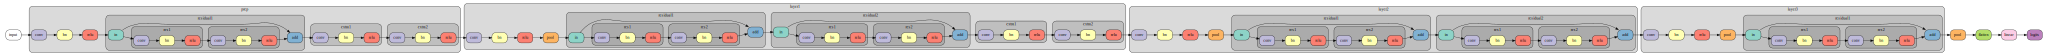

In [12]:
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}, size=35)
draw(build_graph(n))

In [13]:
def implace_draw(graph):
    return DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}, size=35)

In [14]:
colors = ColorMap()
aa = build_graph(n)

In [17]:
implace_draw(aa).save()

save a.svg


In [15]:
help(implace_draw(aa))

Help on DotGraph in module core object:

class DotGraph(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, graph, size=15, direction='LR')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  dot_graph(self, **kwargs)
 |  
 |  save(self, **kwargs)
 |  
 |  svg(self, **kwargs)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  pydot = <module 'pydot' from '/home/ubuntu/anaconda3/envs/pytorch_p36/...



In [ ]:
remove_identity_nodes = lambda net: remove_by_type(net, Identity)
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}, size=45)
draw(build_graph(n))

### Download and preprocess data

图像处理过程中的一些步骤（填充、标准化、位移等等）每经过训练集一次就要重新处理一遍，会浪费很多时间。虽然提前预处理可以用多个CPU处理器减轻这一结果，但是PyTorch的数据下载器会从每次数据迭代中开始新一次的处理。这一配置时间是很短的，尤其在CIFAR10这样的小数据集上。
**只要在训练前做了准备，减少预处理压力，就能减少处理次数。遇到更复杂的任务，需要更多预处理步骤或多个GPU时，就会在每个epoch之间保持数据下载器的处理。** 溢出了重复工作、减少了数据下载器后，训练时间达到了308秒。

大部分预处理时间都花在了 **召集随机数字生成器** ，选择数据增强而不是为它们本身增强。在完全训练时期，我们对随机数字生成器执行了几百万个单独命令，把它们结合在一个较小的命令中，每个epoch可以省去7秒训练时间。最终的训练时间缩短到了297秒

In [4]:
DATA_DIR = './data'
dataset = cifar10(root=DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
valid_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 1.9 seconds
Preprocessing test data
Finished in 0.088 seconds


### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

[Batch的大小、灾难性遗忘将如何影响学习率](https://myrtle.ai/learn/how-to-train-your-resnet-2-mini-batches/)

目前，训练使用的batch大小是128，batch更大，就支持更高效的计算，所以我们想试试当batch增大到512会发生什么。如果我们想估计之前的设置，就需要保证学习率和其他超参数都经过合适的调整。

具有mini-batch的随机梯度下降几乎是每次只训练一个样本，但不同的是，参数的更新会延迟到batch结束。在低学习率的限制下，你可以认为这种延迟是更高阶的效应，只要梯度只在mini-batch上求和而不是计算平均数，批处理就不会改变任何一阶的顺序。我们还在每个batch之后应用了权重衰减，它会通过batch size中的一个因素增加，从而抵消需要处理的batch数量。如果梯度根据mini-batch被平均，那么学习速率应该增加到可以消除这一影响只留下权重衰减，因为权重衰减的更新对应着学习率的因子。

所以现在我们将batch size定为512开始训练。训练时间为256秒，将学习速率增加10%，在128的batch size下，3/5的训练都能达到94%的测试精确度。如之前所料，在512的batch size下，验证结果有更大的噪声，这是因为批规范化的影响。


考虑到要用不同的mini-batch进行训练，我们认为这一过程中我们忽略了两点。首先，我们认为延迟更新，直到这一mini-batch结束都是更高阶的影响，这在较低的学习率中是可行的。目前配置中的快速训练速度很大程度上取决于高学习率的使用。在凸优化的背景下（或仅仅是二次方的梯度下降），我们可以在某一点设置学习速率，达到最大的训练速度，在这一点处，二阶效应开始平衡一阶效应，并且一阶步长产生的益处可以通过曲率效应抵消。假设我们处于这种状态mini-batch导致的延迟更新应该产生相同的曲率惩罚，因为学习率的增加，训练会变得不稳定。简而言之，如果可以忽略高阶效应，就说明训练速度不够快。

另外，我们发现训练步骤只有一个，但事实上，训练是一个很长的运行过程，要改变参数就需要好几个步骤。所以，小的batch和大的batch训练之间的二阶差异可以随着时间积累，导致训练轨迹有很大不同。在之后的文章中我们会重新讨论这一点。

所以，我们该如何在限制训练速度的情况下，还可以提高batch size，同时不用维持曲率效应带来的不稳定性？答案可能是其他因素在限制学习速率，而我们并没有考虑到曲率效应。我们认为这一其他因素就是“灾难性遗忘（Catastrophic Forgetting）”，这也是在较小batch中限制学习率的原因。

首先，我们要对这一概念进行解释。这一术语通常用于，当一个模型在一个任务上训练后，又应用到第二第三个模型上。但是学习之后的任务会导致性能下降，有时这种影响是灾难性的。在我们的案例中，这些任务是来自同一个训练集的不同部分，所以单单在一个epoch中就会发生遗忘现象。学习速率越高，训练中参数所用的越多，在某一点时这会削弱模型吸收信息的能力，早期的batch就会更容易遗忘。

当我们提高batch size时，并没有立即增加模型的稳定性。如果是曲率导致的，稳定性会利可增加。反之，如果是遗忘是主要原因，模型不会受batch size的影响。

之后，我们进行了实验将曲率的效应和遗忘性区分开。曲率效应大多依赖于学习率，而遗忘主要受学习率和数据集大小的共同影响。我们绘制了在batch size为128时，训练和测试损失的折线图，训练所用的是不同大小的子集。

可以看到，首先，训练和测试损失都在学习速率为8的地方突然变得不稳定，这说明曲率影响在这里变得非常重要。相反，其他地方的训练和测试损失都很平稳。

如我们所料，优化学习速率因子（由测试集损失测定）和全部的训练数据集中的优化学习速率因子很接近。对于更小的数据集来说，优化学习速率因子更高。这也符合我们上面的假设：对于一个足够小的数据及来说，遗忘就不再是问题了，学习速率才是问题。对于更大的数据集，在遗忘的影响下，优化点会更低。

同样，在batch size为512的情况下，曲线图也很有趣。由于batch size比上方的大了4倍，曲线出现不稳定情况的速度更快了，当学习速率为2时即出现。我们仍然希望，学习速率因子的优化值和损失与128时的相近，因为遗忘并不对batch size产生影响。以下是得到的结果：

我们设置batch size=128，然后用一定学习速率训练，在前五个epoch中线性增加，之后达到固定的速率并继续训练25个epoch。我们在两个数据集上进行了比较：a)50%的完全训练集没有经过数据增强；b)全部数据都经过增强的数据集。当模型在b上运行时，我们将它停止，重新计算最后几个epoch的损失，这样做的目的是比较模型在最近的数据上得到的损失和此前数据上计算出的损失。

以下是学习速率是原始训练时4倍的结果：


以下是原始训练是现在学习速率4倍的结果：

从第一组图表中，我们发现，与高学习速率相对应，测试损失几乎和模型在a、b上训练时的结果一样。这说明，训练无法从b和a中提取信息。右边的图也证明了这一结果，最近训练的batch表现出比此前的batch更低的损失，但是在半个epoch之内，损失又恢复到模型在从未见过的测试样本上的水平。这说明，模型忘记了在同一个epoch中它此前看到的东西，这也说明这一学习速率限制了它能吸收到的信息。

第二组图表表现出了相反的结果。全部经过数据增强的数据集导致了更低的测试损失，最近的训练batch比此前表现得更好。

结语
上述结果表明，如果我们想训练一个拥有较高学习速率的神经网络，那么就要考虑两点。对于目前的模型和数据集来说，在128的batch size下，我们不会受到遗忘的影响，要么可以找方法降低影响（例如用更大的、伴有稀疏更新的模型或者自然梯度下降），要么可以增大batch size。当batch size达到512时，曲率就开始影响结果，我们关注的重点应该转移到曲率上来。

对于更大的数据集，例如ImageNet-1k，遗忘的影响会更严重。这就能解释为什么在小的batch size、高学习率的训练中加速会失败。

[正则化](https://myrtle.ai/learn/how-to-train-your-resnet-3-regularisation/)

我们在256秒内将模型在CIFAR10上训练到94%的测试精确度。相比之下，基于单个V100 GPU上100%的计算效率，初始基线为341秒，而我们理想中的40秒的目标略微不切实际。今天，我们将定一个适中的目标——超越fast.ai在DAWNBench中的获胜记录，其中使用了8个GPU，训练了174秒。我们会继续使用单个GPU，因为距离使用所有FLOP，我们还离得很远。

对于目前的设置，我们能得对所需要的时间进行大致对比，我们选择性地删除了计算中的某些部分，并运行了剩下部分。例如，我们可以现在GPU上预装随机训练数据，省去数据下载和迁移的时间。我们还能删除优化器步骤和ReLU以及批规范层，只留下卷积层。如果这样做，不同batch size所用时间如下：


这里有几点明显特征。首先，批标准化占用了很大一部分时间。其次，卷积的主要部分也占用了超过一半的计算时间，比我们预计的在100%计算力上用掉一半的时间还要长。第三，优化器和数据下载步骤并不是主要问题。

在GPU专家Graham Hazel的帮助下，我们查看了一些配置文件，迅速发现了批标准化的一些问题——用PyTorch（0.4版本）将模型转换为半精度的默认方法会触发一个慢速代码路径，该路径不使用优化的CuDNN例程。如果我们将批标准化的权重转换回单精度，那么快速代码就被激发，所用时间看起来就更正常了：


经过改进，在35个epoch内训练达到94%的精度只需要186秒，越来越接近我们的目标了！

除此之外，还有很多方法能改进训练，将时间缩短至174秒。GPU代码还可以进一步优化，例如，当前的激活数据以NCHW格式存储，但TensorBoard中的快速CuDNN卷积例程希望数据遵循NHWC的顺序。所以，在卷积前后执行前向和后向转置需要占用很大一部分运行时间。由于PyTorch 0.4不支持原生NHWC计算，并且在其他框架中似乎没有成熟的支持，这一问题会在之后的文章中重点关注。

将训练时间减少到30个epoch，时间也会减少到161秒，轻松打破目前的记录。但如果仅仅加速基准学习速率，在5次运行中没有能达到94%的案例。

在CIFAR10上一中有效的简单正则化策略就是“Cutout”正则化，它可以清除每张训练图片中的随机子集。我们在训练图像选取随机8×8方形子集进行实验，除此之外还有标准的数据增强，用于填补、裁剪、随机翻转。

在基线35个epoch训练后的结果都达到了94%的精确度，其中还有一次达到了94.3%，这也是在基线上的小进步。对学习率进行手动优化后，运行精度达到了94.5%（将峰值学习速率提前，用简单的线性衰减替换衰减相位）。

如果我们在30个epoch上提高学习速率，4/5的运行次数会达到94%的精度，中间值为94.13%。我们可以将batch size提高到768，4/5也能达到94%，中值为94.06%。当batch size为512时，30epoch运行时间为161秒，当batch size为768时，时间为154秒，所有都只在一个GPU上，打破了我们的目标！折线图如下：

不过我们的新纪录应该能很容易打破，首先，我们一直将单个GPU的计算能力维持在25%以下，之后还有对其优化的方法。第二，可以用相关技术减少训练epoch，例如Mixup正则化和AdamW训练。我们尚未研究如何对参数平均以加速最终收敛，如果我们打算在推理时做更多工作，则可以使用测试时间增强来进一步缩短训练时间。还有人提出在更大的网络中进行小于20个epoch的实验训练，结合fast.ai的技术，进一步研究也许会发现更有趣的结果


In [6]:
epochs=3 # 24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
train_transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 3

train_batches = DataLoader(Transform(train_set, train_transforms), batch_size, shuffle=True, set_random_choices=True, drop_last=True)
valid_batches = DataLoader(valid_set, batch_size, shuffle=False, drop_last=False)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = Network(net()).to(device).half()
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(epochs):
        logs.append(union({'epoch': epoch+1}, train_epoch(state, Timer(torch.cuda.synchronize), train_batches, valid_batches)))
        
logs.df().query(f'epoch=={epochs}')[['train_acc', 'valid_acc']].describe()

Starting Run 0 at 2020-07-18 05:26:45
       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       4.4236       1.6348       0.4128       0.4234       1.2952       0.5283       4.8470
           2       3.1179       0.9377       0.6665       0.2154       0.9638       0.6788       3.3334
           3       3.1387       0.7274       0.7458       0.2134       0.8139       0.7316       3.3521
Starting Run 1 at 2020-07-18 05:26:59
       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   epoch time
           1       3.1101       1.6438       0.4085       0.2135       1.2702       0.5581       3.3236
           2       3.1122       0.9555       0.6594       0.2134       1.2604       0.6156       3.3256
           3       3.1090       0.7328       0.7433       0.2133       1.1087       0.6338       3.3223
Starting Run 2 at 2020-07-18 05:27:10
       epoch   train time   train loss    train acc   

,train_acc,valid_acc
count,1.000000,1.0000
mean,0.747926,0.7595
std,NaN,NaN
min,0.747926,0.7595
25%,0.747926,0.7595
50%,0.747926,0.7595
75%,0.747926,0.7595
max,0.747926,0.7595


In [ ]:
# test pareto optimal repo

In [11]:
!pip install gurobi==

ERROR: Could not find a version that satisfies the requirement gurobi== (from versions: none)
ERROR: No matching distribution found for gurobi==


In [1]:
!git clone https://github.com/xuan0802/state-load-placement.git

Cloning into 'state-load-placement'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 2.90 MiB | 7.07 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [9]:
!pwd && cd state-load-placement && python Load_state.py

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
Traceback (most recent call last):
  File "Load_state.py", line 7, in <module>
    from gurobipy import Model, GRB
ModuleNotFoundError: No module named 'gurobipy'


In [12]:
!git clone https://github.com/doublsky/aladdin_bench.git

Cloning into 'aladdin_bench'...
remote: Enumerating objects: 611, done.
remote: Total 611 (delta 0), reused 0 (delta 0), pack-reused 611
Receiving objects: 100% (611/611), 92.90 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [14]:
!pwd && cd aladdin_bench && python pareto.py

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
  File "pareto.py", line 47
    print "Raw Data Size:", df.shape
                         ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Raw Data Size:", df.shape)?


In [15]:
!git clone https://github.com/RoydeZomer/CEGO.git

Cloning into 'CEGO'...
remote: Enumerating objects: 330, done.
remote: Total 330 (delta 0), reused 0 (delta 0), pack-reused 330
Receiving objects: 100% (330/330), 1.45 MiB | 20.87 MiB/s, done.
Resolving deltas: 100% (181/181), done.


In [18]:
!pwd && ls && mv test_5.py CEGO/

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
CEGO		       config.yml     demo.ipynb	 new_dawn.py
README.md	       core.py	      experiments.ipynb  search_space.json
__pycache__	       data	      hpo_experiment	 state-load-placement
aladdin_bench	       data_cifar100  logs.tsv		 test_5.py
bag_of_tricks.ipynb    dawn.py	      main.py		 torch_backend.py
batch_norm_post.ipynb  dawn_utils.py  net.svg


In [23]:
!pwd && ls && mv test_5.py CEGO/test_6.py

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
CEGO		       config.yml     demo.ipynb	 new_dawn.py
README.md	       core.py	      experiments.ipynb  search_space.json
__pycache__	       data	      hpo_experiment	 state-load-placement
aladdin_bench	       data_cifar100  logs.tsv		 test_5.py
bag_of_tricks.ipynb    dawn.py	      main.py		 torch_backend.py
batch_norm_post.ipynb  dawn_utils.py  net.svg


In [27]:
!pwd && ls && cd CEGO && ls && mv test_5.py CEGO/

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
CEGO		       config.yml     demo.ipynb	 new_dawn.py
README.md	       core.py	      experiments.ipynb  search_space.json
__pycache__	       data	      hpo_experiment	 state-load-placement
aladdin_bench	       data_cifar100  logs.tsv		 torch_backend.py
bag_of_tricks.ipynb    dawn.py	      main.py
batch_norm_post.ipynb  dawn_utils.py  net.svg
 CEGO		   'help plots'			 test.py     test_5.py
 LICENSE	   'help scripts'		 test_2.py   test_6.py
 README.md	   'obtained Pareto frontiers'	 test_3.py
 convergencePlots   pseudocode.PNG		 test_4.py


In [31]:
!pip install pygmo

     |████████████████████████████████| 12.1 MB 15.1 MB/s eta 0:00:01


In [33]:
!pwd 

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series


In [ ]:
!pwd && ls && cd CEGO/CEGO && python test_5.py

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
CEGO		       config.yml     demo.ipynb	 new_dawn.py
README.md	       core.py	      experiments.ipynb  search_space.json
__pycache__	       data	      hpo_experiment	 state-load-placement
aladdin_bench	       data_cifar100  logs.tsv		 torch_backend.py
bag_of_tricks.ipynb    dawn.py	      main.py
batch_norm_post.ipynb  dawn_utils.py  net.svg
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
increasing epsilon to: 0.02
incre

In [35]:
!pwd && ls && cd CEGO/CEGO && python test_final.py

/home/ubuntu/2_workspace/nni_hpo/3rdparty/Efficient-CIFAR-Series
CEGO		       config.yml     demo.ipynb	 new_dawn.py
README.md	       core.py	      experiments.ipynb  search_space.json
__pycache__	       data	      hpo_experiment	 state-load-placement
aladdin_bench	       data_cifar100  logs.tsv		 torch_backend.py
bag_of_tricks.ipynb    dawn.py	      main.py
batch_norm_post.ipynb  dawn_utils.py  net.svg
Traceback (most recent call last):
  File "test_final.py", line 6, in <module>
    problemCall = CEXP
NameError: name 'CEXP' is not defined


[12.0, 13.0, 14.0, 17.0, 19.0] [67.0, 66.0, 55.0, 43.0, 32.0]


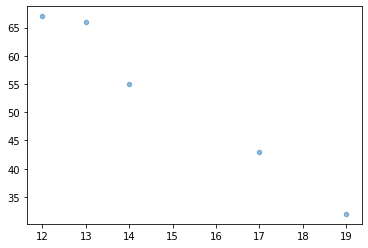

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt  
import numpy as np

def Read_Files(filename):
    X_axis = []  # X
    Y_axis = []  # Y
    with open(filename, 'r') as f:
        for line in f.readlines():
            x = line.split(" ")[0]
            y = line.split(" ")[1]
            X_axis.append(float(x))
            Y_axis.append(float(y))
    f.close()
    return X_axis, Y_axis

def plot_PF(X_axis, Y_axis):
    # 可以通过c 参数设置颜色
    # T = np.arctan2(Y_axis, X_axis)
    # plt.scatter(X_axis, Y_axis, s=2, c=T, alpha=0.5)
    plt.scatter(X_axis, Y_axis, s=20, alpha=0.5)
    plt.savefig(Figname + '.png', dpi=600)
    plt.show()

Filename = './hpo_experiment/sample.txt'
Figname='CIHS1_hType_circle'
X_axis, Y_axis = Read_Files(Filename)
print(X_axis, Y_axis)
T = np.arctan2(Y_axis, X_axis)
plot_PF(X_axis, Y_axis)


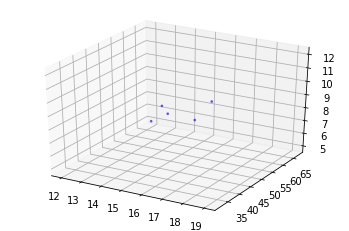

In [52]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


def Read_Files(filename):
    X_axis = []  # X
    Y_axis = []  # Y
    Z_axis = []  # Z
    with open(filename, 'r') as f:
        for line in f.readlines():
            # print(line)
            # x = line.split("\t")[0]  # 注意，这里不是使用空格，而是使用Tab制表符进行分割
            # print(x)
            # y = line.split("\t")[1]
            # print(y)
            # z = line.split("\t")[2]
            # print(z)
            
            x = line.split(" ")[0]  # 注意，这里不是使用空格，而是使用Tab制表符进行分割
            # print(x)
            y = line.split(" ")[1]
            # print(y)
            z = line.split(" ")[2]
            # print(z)
            
            X_axis.append(float(x))
            Y_axis.append(float(y))
            Z_axis.append(float(z))
    f.close()
    return X_axis, Y_axis, Z_axis


def plot_PF(X_axis, Y_axis, Z_axis):

    ax = plt.figure().add_subplot(111, projection='3d')
    # c 设置颜色，alpha设置透明度，s设置点的大小
    ax.scatter(X_axis, Y_axis, Z_axis, c='b', alpha=0.5, s=3)

    plt.savefig(Figname + '.png', dpi=600)
    plt.show()


Filename = './hpo_experiment/sample_3d.txt'
Figname = 'hType_sphere'
X_axis, Y_axis, Z_axis = Read_Files(Filename)
plot_PF(X_axis, Y_axis, Z_axis)

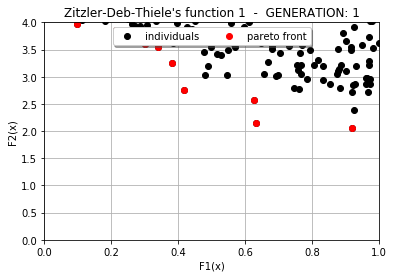

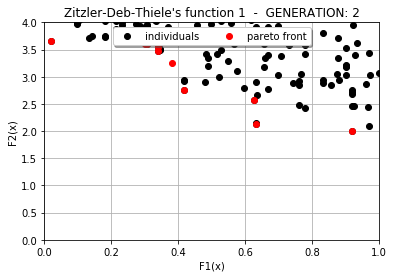

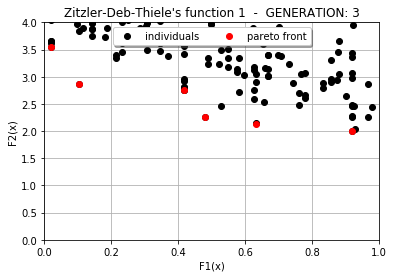

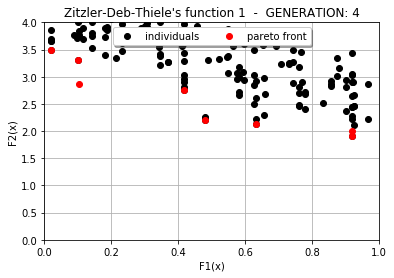

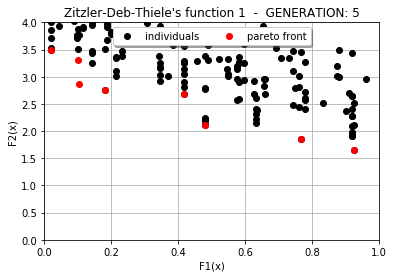

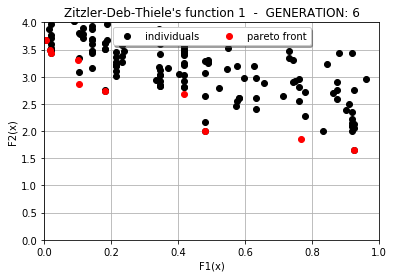

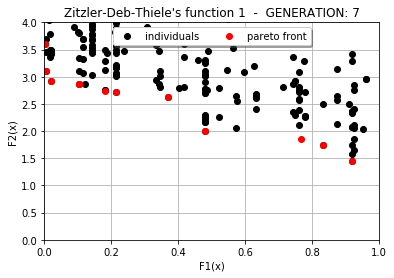

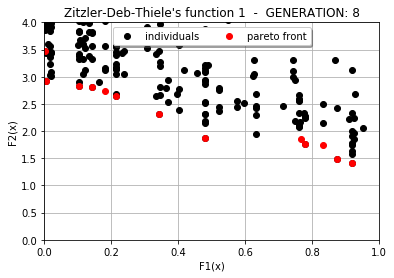

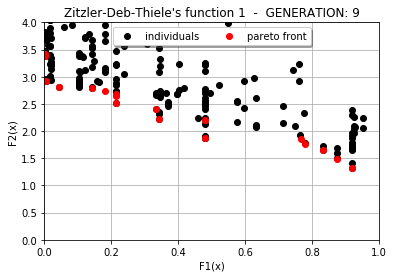

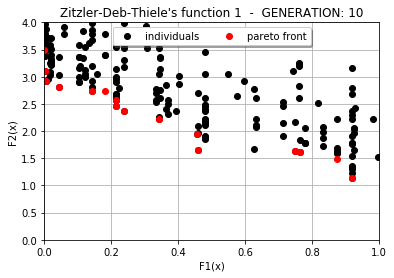

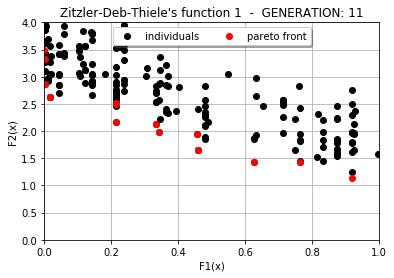

KeyboardInterrupt: 

In [60]:
import math
import NPGA
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def scaleMinMax(x, xmin, xmax, mindesired, maxdesired):
	return ((x - xmin) / (xmax - xmin) * (maxdesired - mindesired) + mindesired)

def graytodec(bin_list):
	"""
	Convert from Gray coding to binary coding.
	We assume big endian encoding.
	"""
	b = bin_list[0]
	d = int(b) * (2**(len(bin_list)-1))
	for i, e in enumerate(range(len(bin_list) - 2, -1, -1)):
		b = str(int(b != bin_list[i + 1]))
		d += int(b) * (2**e)
	return d

def decodechromosome(bits, BitsForEachNumber, SizeVector):
	x = np.zeros((SizeVector,), dtype = np.float64)
	for i in range(SizeVector):
		dec = graytodec(bits[(i * BitsForEachNumber) : (i * BitsForEachNumber + BitsForEachNumber)])
		max_current = math.pow(2, BitsForEachNumber) - 1
		x[i] = scaleMinMax(dec, 0, max_current, 0, 1)
	return x

def ZDT1(x):
	f1 = x[0]
	g = 1 + 9 * (np.sum(x[1:]) / (len(x)- 1))
	f2 = g * (1 - np.sqrt(x[0] / g))
	return f1, f2

def ZDT2(x):
	f1 = x[0]
	f2 = -math.exp(-x[0])
	return f1, f2

def getfitness(candidate, BitsForEachNumber, SizeVector):
	x = decodechromosome(candidate, BitsForEachNumber, SizeVector)
	# print(x)
	F1, F2 = ZDT1(x)
	return [[F1, 'minimize'], [F2, 'minimize']]

class StaticGen:
	Generation = 1

def display(statistics):
	f1x = []
	f2x = []
	for point in statistics.ParetoSet:
		f1x.append(point.Fitness[0])
		f2x.append(point.Fitness[1])

	xpop = []
	ypop = []
	for individual in statistics.population:
		xpop.append(individual.Fitness[0])
		ypop.append(individual.Fitness[1])


	plt.figure(1)
	plt.clf()
	plt.axis([0, 1, 0, 4])
	plt.xlabel('F1(x)')
	plt.ylabel('F2(x)')
	plt.plot(xpop, ypop, 'ko', label='individuals')
	plt.plot(f1x, f2x, 'ro', label='pareto front')
	plt.title('Zitzler-Deb-Thiele\'s function 1  -  GENERATION: ' + str(StaticGen.Generation))
	plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
	plt.grid()
	plt.draw()
	plt.pause(0.0001)
	plt.show(block=False)

	StaticGen.Generation = StaticGen.Generation + 1

def test():
	geneset = '01'
	BitsForEachNumber = 16
	SizeVector = 20
	genelen = [BitsForEachNumber * SizeVector]

	def fnDisplay(statistic): display(statistic)
	def fnGetFitness(genes): return getfitness(genes, BitsForEachNumber, SizeVector)

	optimalFitness = [0, 0]

	GA = NPGA.NichedParetoGeneticAlgorithm(
							fnGetFitness, fnDisplay, optimalFitness,
							geneset, genelen, population_size = 200,
							max_generation = 400, crossover_rate = 0.65,
							mutation_rate = 1/170, niche_radius = 0.02,
							candidate_size = 4, prc_tournament_size = 0.13,
							fastmode = True)
	GA.Evolution()


test()
plt.show()


(16, 10)
gamma:
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
beta:
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
gamma:
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
beta:
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
1e-05
输入的第一个维度平均值：
tensor(8.9626)
输入的第一个维度方差：
tensor(0.2087)
torch.Size([10, 1, 1])


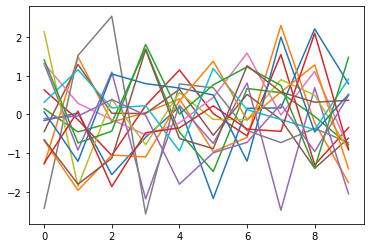

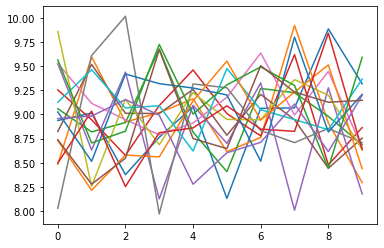

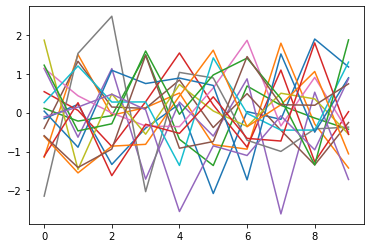

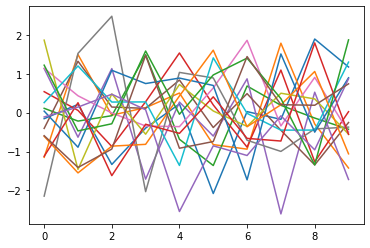

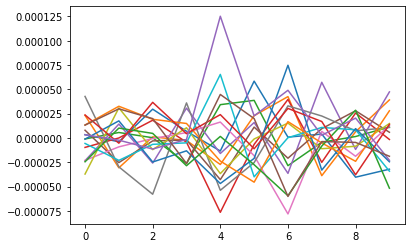

In [88]:
## test batchnorm
import torch
from torch import nn

mini_batchsize=16
with_grad = True


if with_grad:
    m = nn.BatchNorm2d(10)
else:
    m = nn.BatchNorm2d(10, affine=False) # without grad

input = torch.randn(mini_batchsize, 10, 1, 1) # nchw
input_c = input * 0.4 + 9 # nchw

if with_grad:
    a = input.detach().numpy()
    c = input_c.detach().numpy()
else:
    a = np.array(input)
    c = np.array(input_c)

print(a.squeeze().shape)
# print(input)

output = m(input)
print('gamma:')
print(m.weight)
print('beta:')
print(m.bias)


output_d = m(input_c)
print('gamma:')
print(m.weight)
print('beta:')
print(m.bias)


"""
firstDimenMean = torch.Tensor.mean(input_c[0])
firstDimenVar= torch.Tensor.var(input_c[0],False) #Bessel's Correction贝塞尔校正不会被使用
# print(m.eps)
print("输入的第一个维度平均值：")
print(firstDimenMean)
print("输入的第一个维度方差：")
print(firstDimenVar)
"""

if with_grad:
    b = output.detach().numpy()
    d = output_d.detach().numpy()
else:
    b=np.array(output)
    d=np.array(output_d)

print(output[1].size())
# print(output[1])

%matplotlib inline
import matplotlib.pyplot as plt
w = np.array(range(10))

for i in range(mini_batchsize):
    pop = a[i].flatten()
    plt.plot(w, pop)

plt.show()

for i in range(mini_batchsize):
    pop = c[i].flatten()
    plt.plot(w, pop)

plt.show()

for i in range(mini_batchsize):
    pop_output=b[i].flatten()
    plt.plot(w, pop_output)
plt.show()


for i in range(mini_batchsize):
    pop_output=d[i].flatten()
    plt.plot(w, pop_output)
plt.show()

# 放缩前后的输入 经过bn之后的输出，两者差距微乎其微
for i in range(mini_batchsize):
    pop_output=d[i].flatten() - b[i].flatten()
    plt.plot(w, pop_output)
plt.show()


In [86]:
import torch
import torch.nn as nn

m = nn.BatchNorm2d(10,affine=True) #权重w和偏重将被使用
input = torch.randn(64,10,1,1)
output = m(input)

# print("输入图片：")
# print(input)
print("归一化权重：")
print(m.weight)
print("归一化的偏重：")
print(m.bias)

# print("归一化的输出：")
# print(output)
print("输出的尺度：")
print(output.size())

# i = torch.randn(1,1,2)
print("输入的第一个维度：")
print(input[0][0])

firstDimenMean = torch.Tensor.mean(input[0][0])
firstDimenVar= torch.Tensor.var(input[0][0],False) #Bessel's Correction贝塞尔校正不会被使用

print(m.eps)
print("输入的第一个维度平均值：")
print(firstDimenMean)
print("输入的第一个维度方差：")
print(firstDimenVar)

bacthnormone = \
    ((input[0][0][0][0] - firstDimenMean)/(torch.pow(firstDimenVar+m.eps,0.5) ))\
               * m.weight[0] + m.bias[0]
print(bacthnormone)


归一化权重：
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
归一化的偏重：
Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
输出的尺度：
torch.Size([64, 10, 1, 1])
输入的第一个维度：
tensor([[0.1580]])
1e-05
输入的第一个维度平均值：
tensor(0.1580)
输入的第一个维度方差：
tensor(0.)
tensor(0., grad_fn=<AddBackward0>)


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn    = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 10)

    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

In [10]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time

import torch
import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)

term_width = 0
try:
    term_width = os.get_terminal_size().columns
except Exception as exception:
    term_width = 200
term_width = int(term_width)

TOTAL_BAR_LENGTH = 5.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f


In [ ]:
'''Train CIFAR10 with PyTorch.'''
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import logging

import nni

_logger = logging.getLogger("cifar10_pytorch_automl")

trainloader = None
testloader = None
net = None
criterion = None
optimizer = None
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0.0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

def prepare(args):
    global trainloader
    global testloader
    global net
    global criterion
    global optimizer

    # Data
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

    #classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Model
    print('==> Building model..')
    net = LeNet()

    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)

    if args['optimizer'] == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)
    if args['optimizer'] == 'Adadelta':
        optimizer = optim.Adadelta(net.parameters(), lr=args['lr'])
    if args['optimizer'] == 'Adagrad':
        optimizer = optim.Adagrad(net.parameters(), lr=args['lr'])
    if args['optimizer'] == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args['lr'])
    if args['optimizer'] == 'Adamax':
        optimizer = optim.Adam(net.parameters(), lr=args['lr'])


# Training
def train(epoch, batches=-1):
    global trainloader
    global testloader
    global net
    global criterion
    global optimizer

    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        acc = 100.*correct/total

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        if batches > 0 and (batch_idx+1) >= batches:
            return

def test(epoch):
    global best_acc
    global trainloader
    global testloader
    global net
    global criterion
    global optimizer

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            acc = 100.*correct/total

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc
    return acc, best_acc


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", type=int, default=2)
    # Maximum mini-batches per epoch, for code testing purpose
    parser.add_argument("--batches", type=int, default=-1)
    args, _ = parser.parse_known_args()

    try:
        # RCV_CONFIG = nni.get_next_parameter()
        RCV_CONFIG = {'lr': 0.1, 'optimizer': 'Adam', 'model':'lenet'}
        _logger.debug(RCV_CONFIG)

        prepare(RCV_CONFIG)
        acc = 0.0
        best_acc = 0.0
        for epoch in range(start_epoch, start_epoch+args.epochs):
            train(epoch, args.batches)
            acc, best_acc = test(epoch)
            nni.report_intermediate_result(acc)

        nni.report_final_result(best_acc)
    except Exception as exception:
        _logger.exception(exception)
        raise


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
 [====>..........]  Step: 36ms | Tot: 3s354ms | Loss: 2.851 | Acc: 10.106% (1397/13824)                                                                                                                                                       84/391                                                                            7/39 8/39 9/391 10/391 11/39 12/391 13/39 14/391                                                                                                              15/391                                                                   16/391 ...]  Step: 28ms | Tot: 494ms | Loss: 5.755 | Acc: 9.835% (214/2176)                                                                                                                                                          17/391                                                                                      